# Switching RA drugs

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
from os.path import join

import joblib
import pandas as pd
from amhelpers.config_parsing import load_config

from inpole.data import get_data_handler_from_config
from inpole.models.utils import expects_groups
from inpole.visualization import *
from inpole.pipeline import load_best_pipeline
from inpole.train_predict import _get_feature_names

In [3]:
%matplotlib inline

## 20231113_1028_sweep

In [4]:
experiment_path = '/mimer/NOBACKUP/groups/inpole/results/ra/20231113_1028_sweep/'

In [5]:
scores_path = join(experiment_path, 'scores.csv')
scores = pd.read_csv(scores_path)

In [6]:
get_score_table(scores, 'auc', factor=100)

,auc,aucmin,aucmax
estimator_name,,,
mlp,90.2,nan,nan
pronet,90.4,nan,nan
prosenet,91.8,nan,nan
rdt,90.9,nan,nan
rnn,91.9,nan,nan
sdt,90.0,nan,nan


In [7]:
get_score_table(scores, 'ece', precision=3)

,ece,ecemin,ecemax
estimator_name,,,
mlp,0.010,nan,nan
pronet,0.017,nan,nan
prosenet,0.020,nan,nan
rdt,0.038,nan,nan
rnn,0.012,nan,nan
sdt,0.005,nan,nan


### Inspect best prototype model

In [8]:
pipeline = load_best_pipeline(experiment_path, trial=1, estimator_name='prosenet')
preprocessor, estimator = pipeline.named_steps.values()

In [9]:
config_path = join(estimator.results_path, 'config.yaml')
config = load_config(config_path)
data_handler = get_data_handler_from_config(config)
X, y = data_handler.get_splits()[0]
if not expects_groups(estimator): 
    X = X.drop(columns='id')
Xt = preprocessor.transform(X)

In [10]:
_, _, encodings = estimator.forward(Xt, training=False)

In [11]:
last_history = estimator.history[-1]
prototype_indices = last_history['prototype_indices']

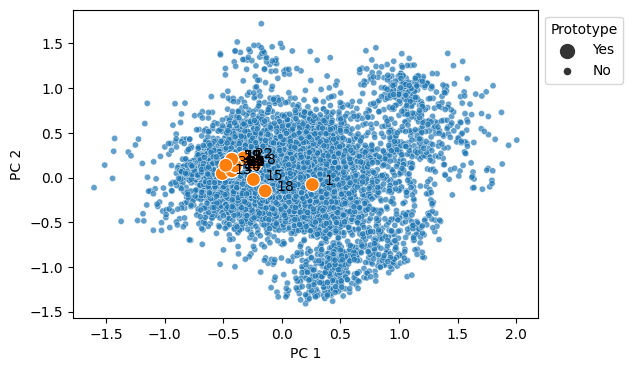

In [12]:
_fig, _ax = visualize_encodings(encodings, prototype_indices)

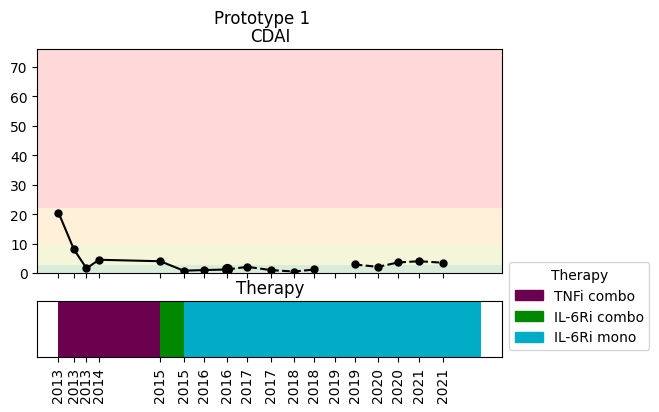

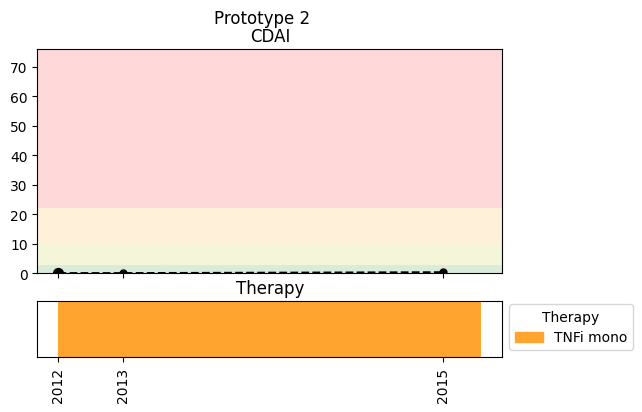

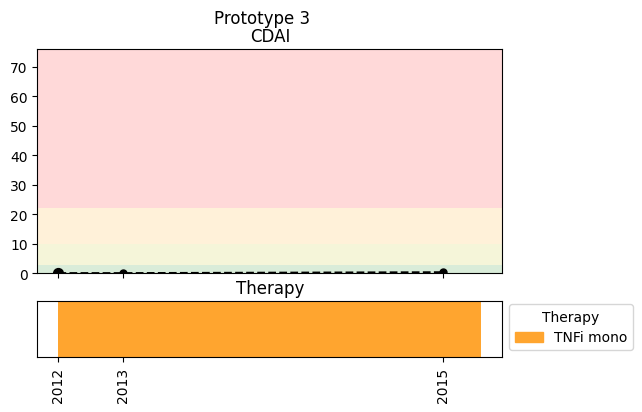

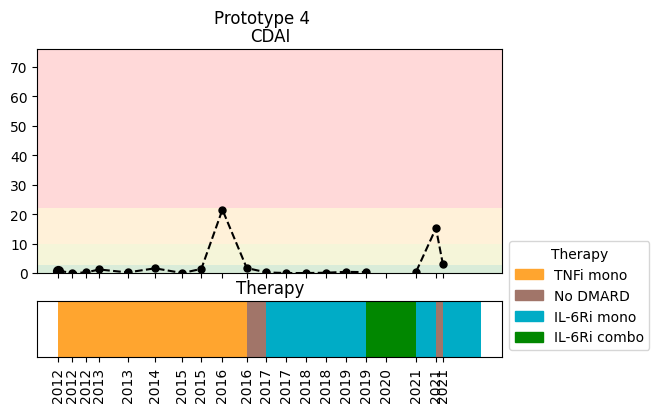

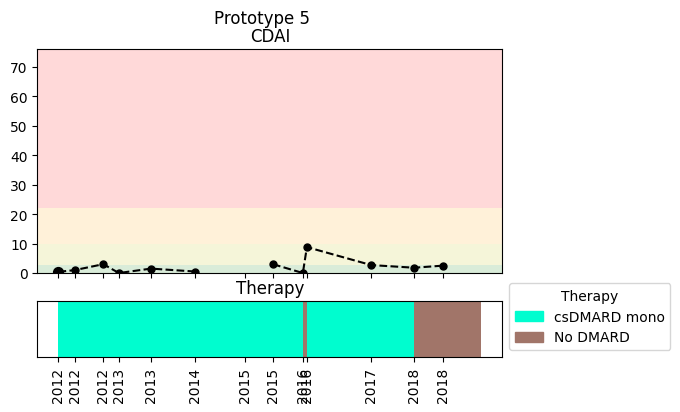

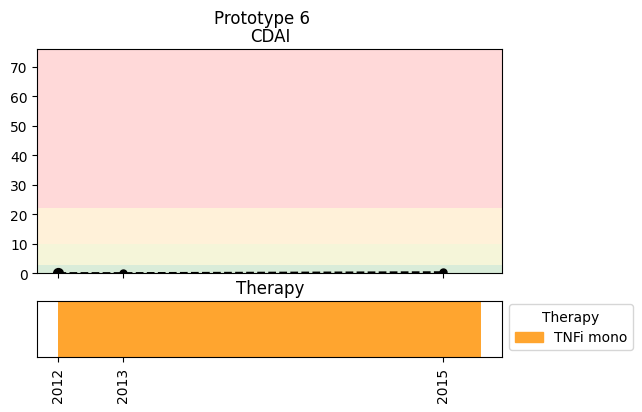

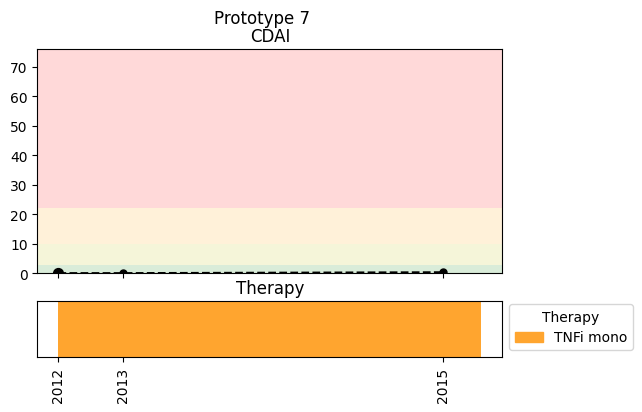

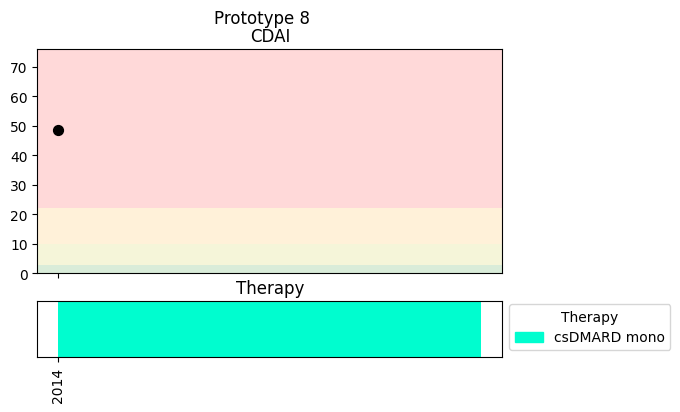

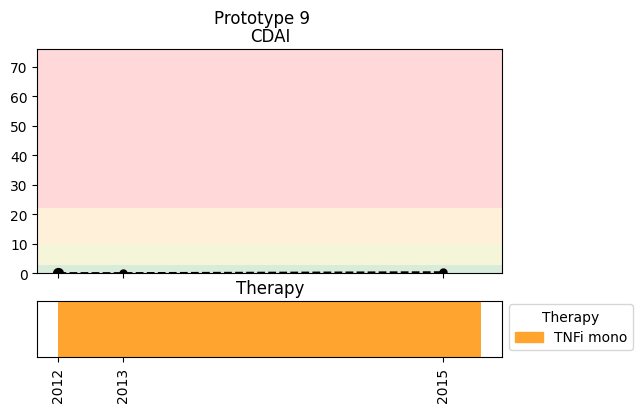

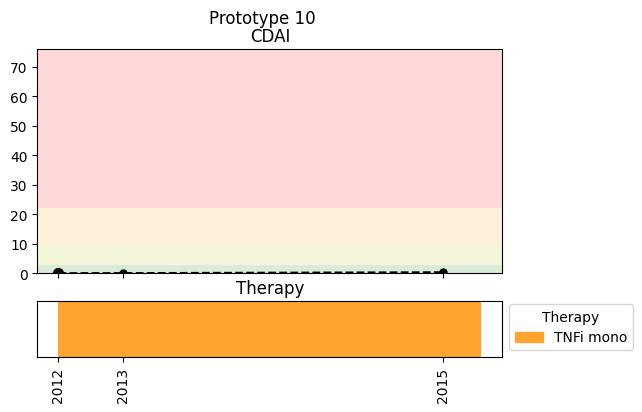

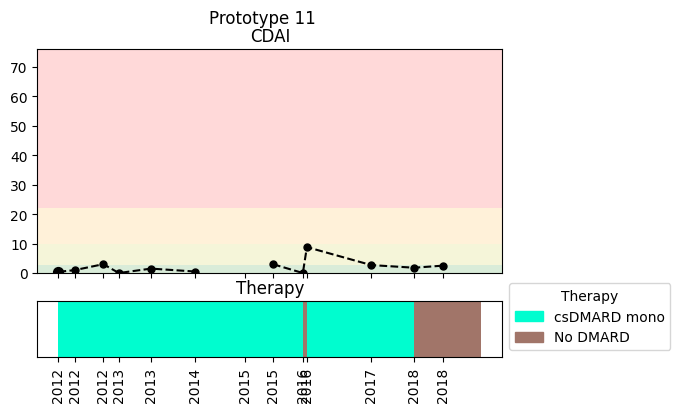

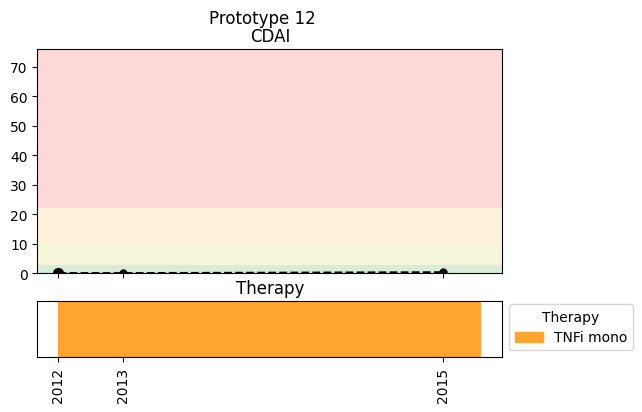

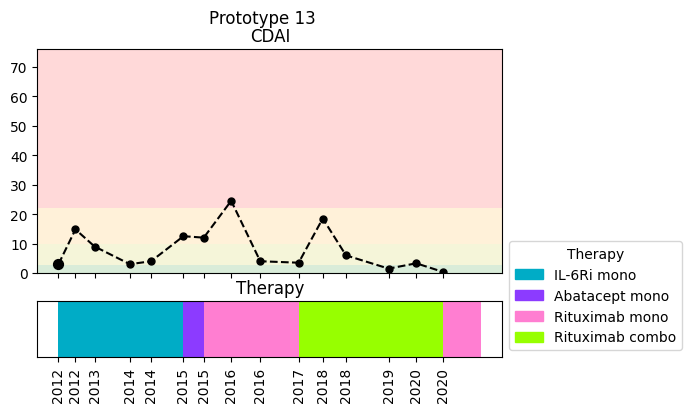

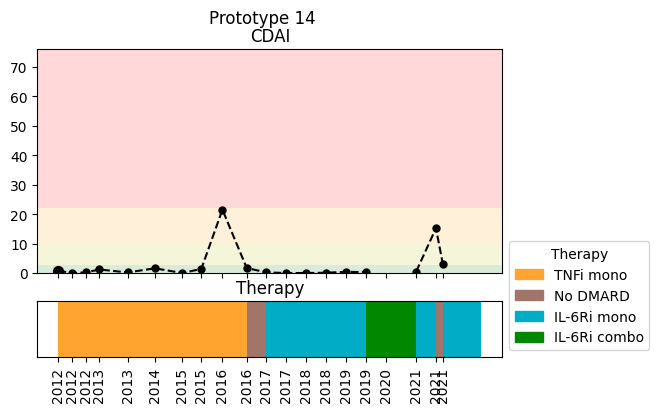

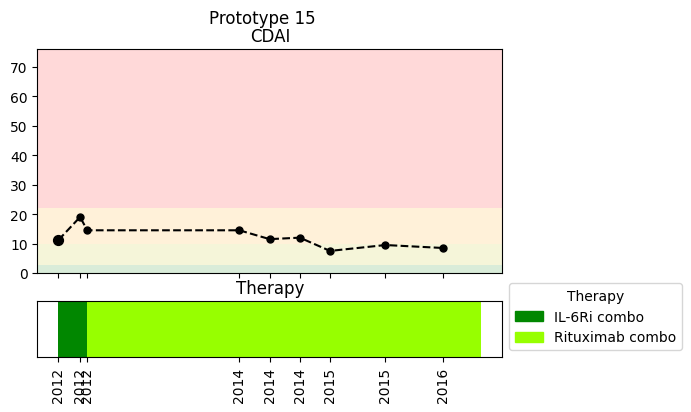

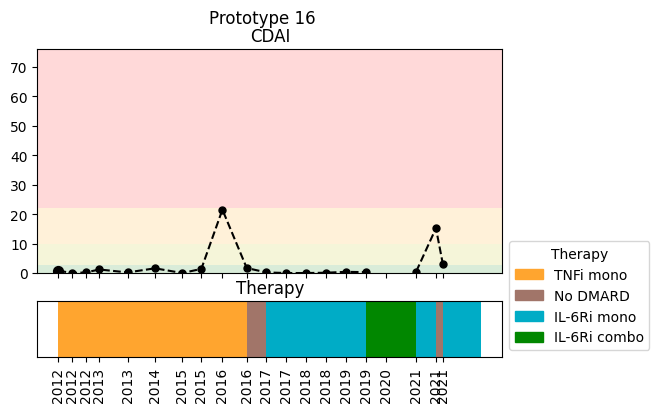

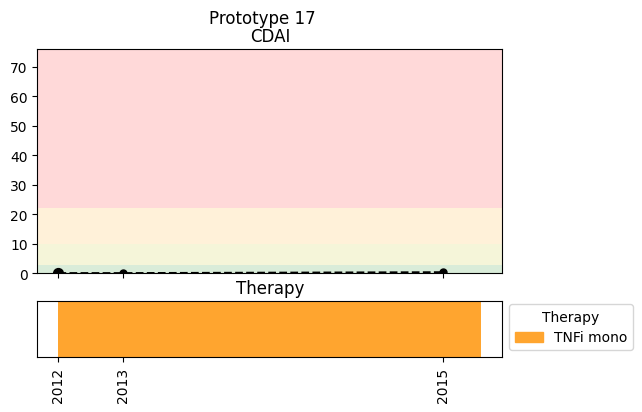

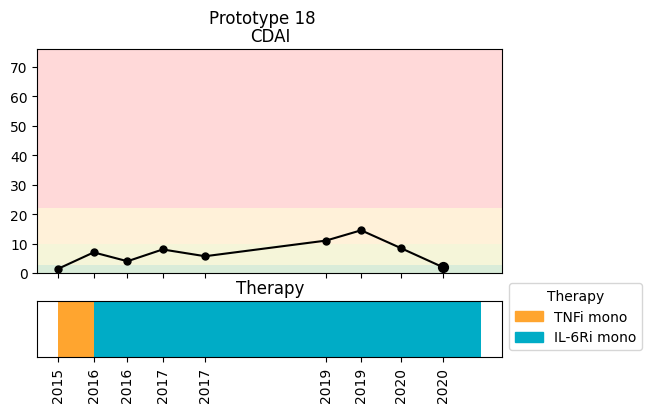

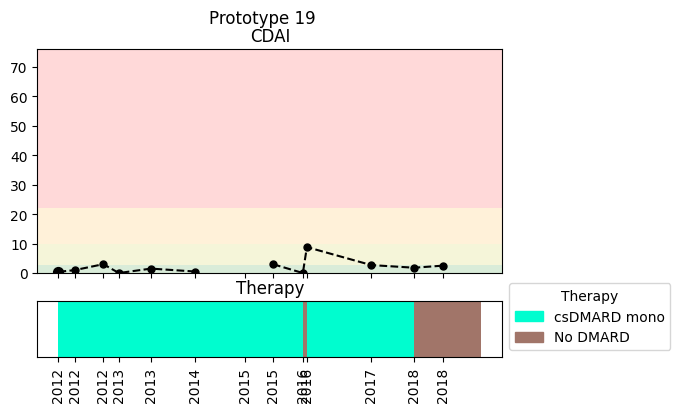

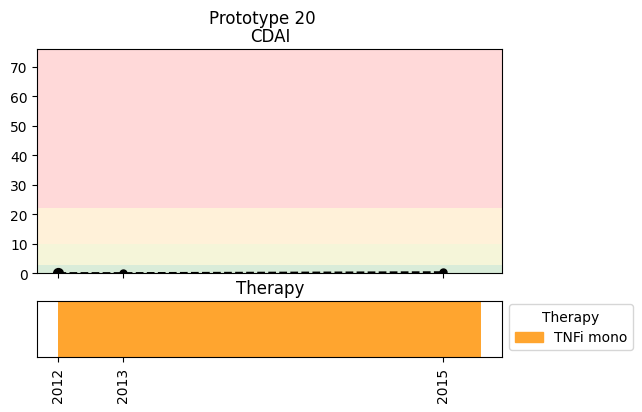

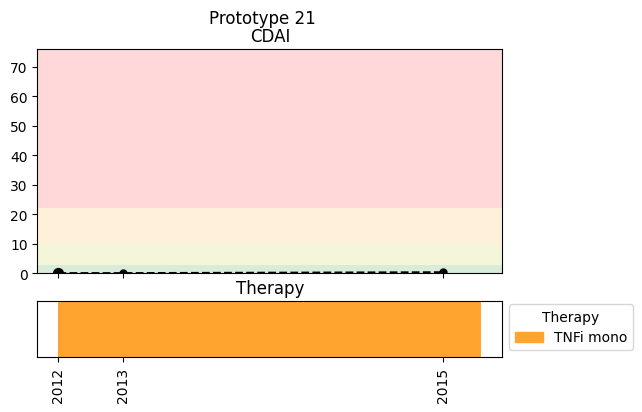

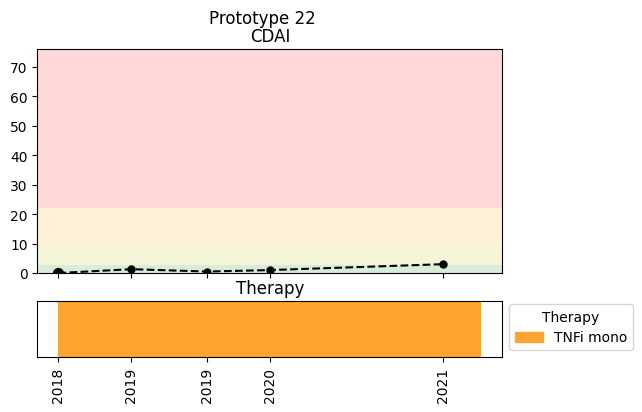

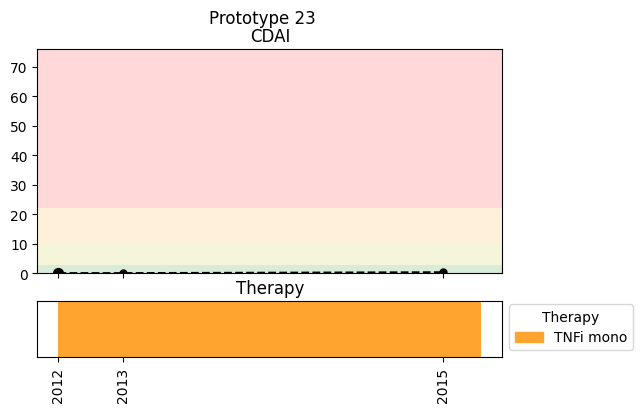

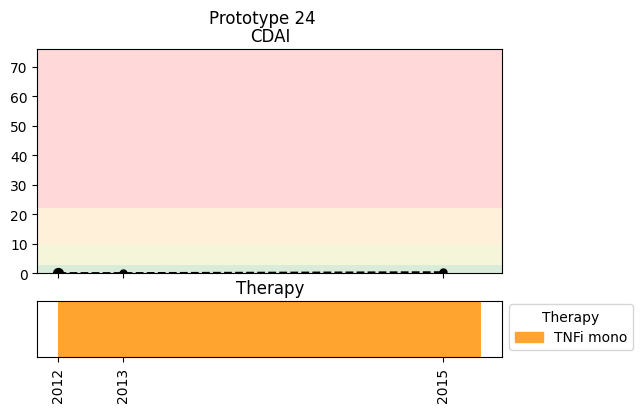

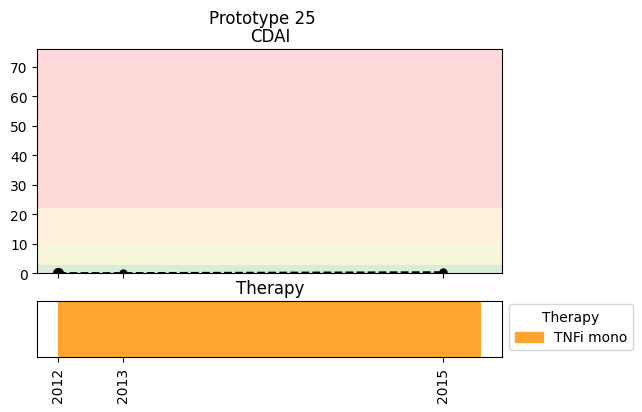

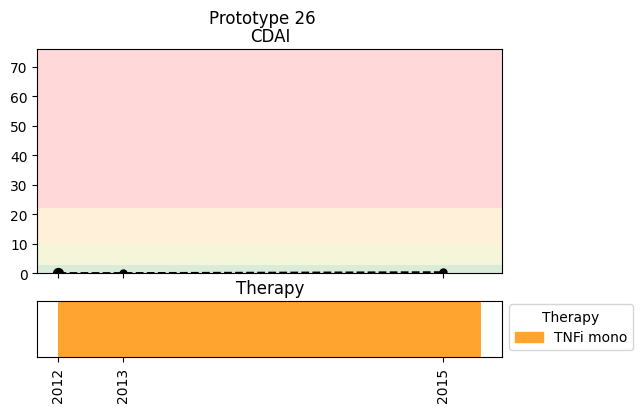

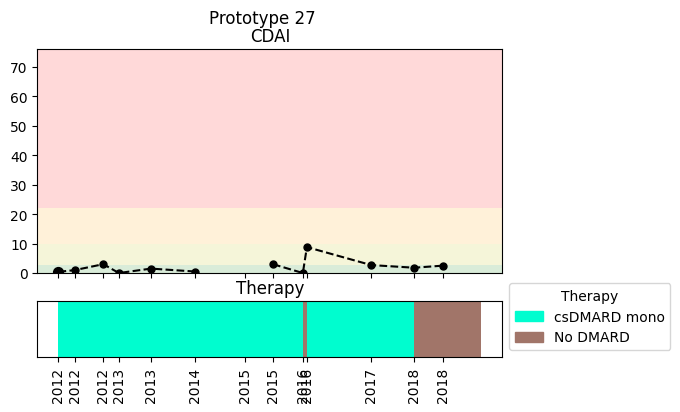

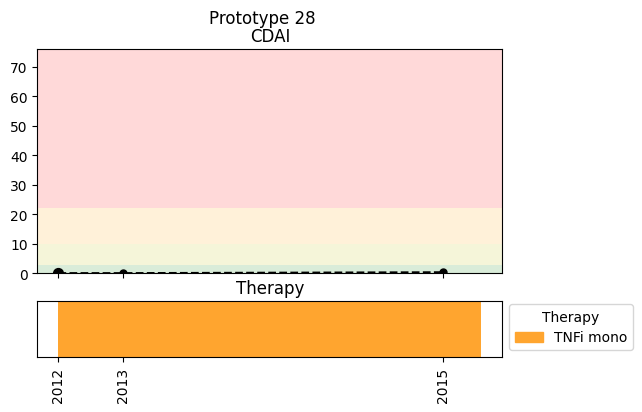

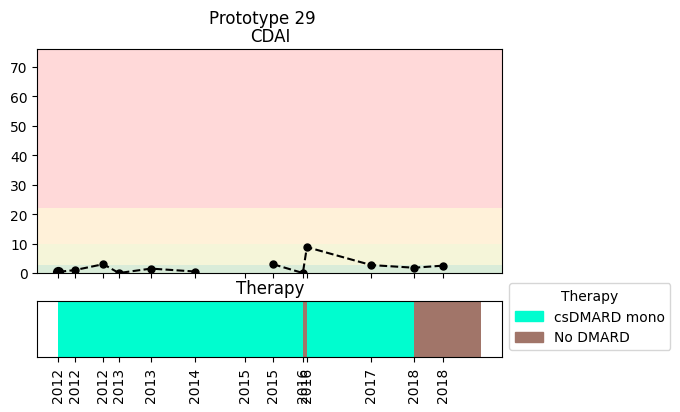

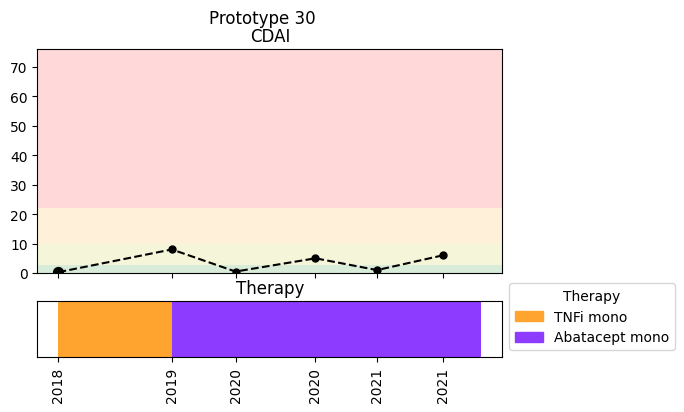

In [13]:
data_path = '/mimer/NOBACKUP/groups/inpole/data/ra_data.pkl'
data = pd.read_pickle(data_path)
data = data.loc[X.index]
data.reset_index(inplace=True)

for i, prototype_index in enumerate(prototype_indices):
    fig = visualize_prototype_ra(data, prototype_index)
    fig.suptitle(f"Prototype {i+1}")

### Inspect recurrent decision tree

In [14]:
pipeline = load_best_pipeline(experiment_path, trial=1, estimator_name='rdt')
preprocessor, estimator = pipeline.named_steps.values()

In [15]:
estimator.module_.prediction

'mean'

In [16]:
estimator.align_axes()

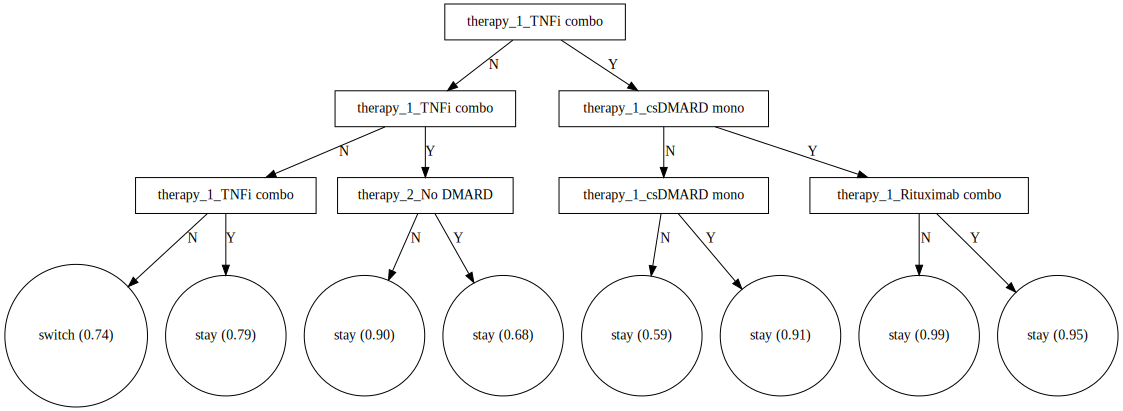

In [17]:
features = _get_feature_names(preprocessor, trim=True)
labels = ['stay', 'switch']
estimator.module_._draw_tree(features, labels)

In [18]:
# Prune the tree.

config_path = join(estimator.results_path, 'config.yaml')
config = load_config(config_path)
data_handler = get_data_handler_from_config(config)

X_valid, y_valid = data_handler.get_splits()[1]
if not expects_groups(estimator): 
    X_valid = X_valid.drop(columns='id')
Xt_valid = preprocessor.transform(X_valid)

dataset_valid = estimator.get_dataset(Xt_valid, y_valid)

estimator.prune_tree(dataset_valid)

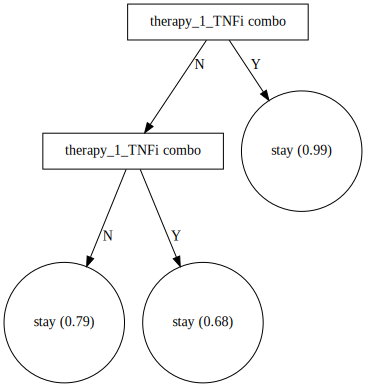

In [19]:
estimator.module_._draw_tree(features, labels)

### Inspect hyperparameters

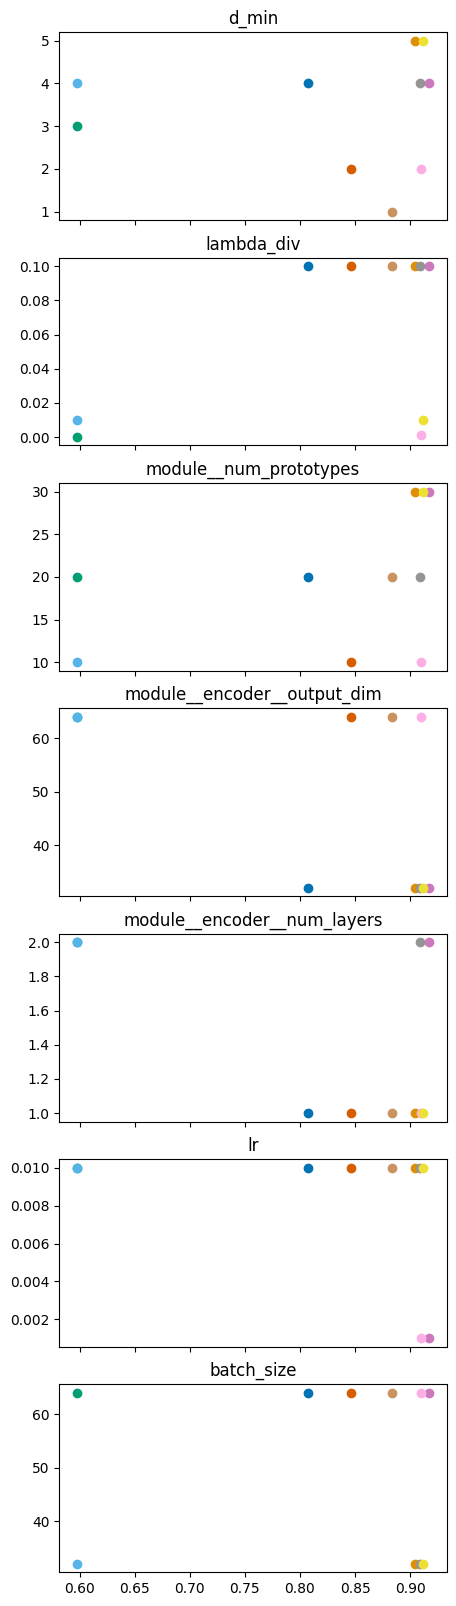

In [21]:
inspect_hyperparameters(experiment_path, estimator_name='prosenet', figsize=(5, 20))

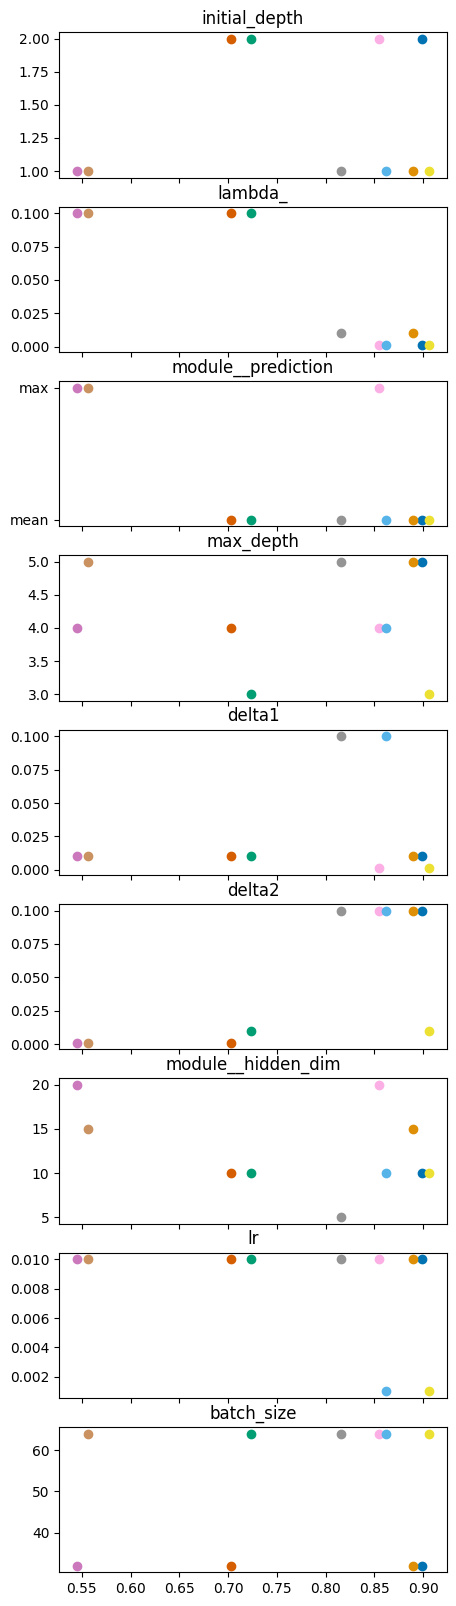

In [20]:
inspect_hyperparameters(experiment_path, estimator_name='rdt', figsize=(5, 20))